<a href="https://colab.research.google.com/github/celinekaram99/Kuzushiji-MNIST/blob/main/Kuzushiji_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Celine Karam***
#314658428

# Import Libraries :



In [ ]:
#importing the libraries
import os
from time import time
import numpy as np

import torch
from torch import nn
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets
from torchvision.transforms import ToTensor # following is needed for converting data to tensors
from torchvision.transforms import transforms
import torchvision.models as models

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


# Load Data :

1. Data Transformer
2. Download
3. Load 
 
It is not strictly necessary to normalize the Kuzushiji MNIST dataset.



**We have data of 60k as training data set with 10k testing data set. All images have 28x28 pixel.**

In [ ]:
# Define the transformation to apply to the images
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# download Training data:
train_data = datasets.KMNIST(
    root      = "data",
    train     = True,       # for Training data
    download  = True,
    transform = ToTensor()  # for converting to tensor
    )

print(train_data )           # 60K training samples
print(train_data.data.shape) # each sample is 28x28 grayscale image

Dataset KMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


In [ ]:
# download Test data
test_data = datasets.KMNIST(
    root      = "data",
    train     = False,      # for Test data
    download  = True,
    transform = ToTensor()  # for converting to tensor
    )
print(test_data)
print(test_data.data.shape)

Dataset KMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([10000, 28, 28])


In [ ]:
# Load Data
# create DataLoader for Training data with batch size 150
train_Dloader = DataLoader(dataset = train_data,batch_size = 150) 

# create DataLoader for Test data with batch size 150
test_Dloader =  DataLoader(dataset= test_data,batch_size = 150)

# Visualization:


The 10 labels:
0: 'か (ka)'
1: 'き (ki)'
2: 'く (ku)'
3: 'け (ke)'
4: 'こ (ko)'
5: 'さ (sa)'
6: 'し (shi)'
7: 'す (su)'
8: 'せ (se)'
9: 'そ (so)'

In [ ]:
labels=[
    "か",
    "き",
    "く",
    "け",
    "こ",
    "さ",
    "し",
    "す",
    "せ",
    "そ"
 ]

し


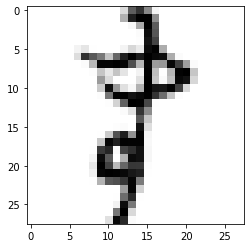

In [ ]:
# Simple function to visualize and find label of a training sample! 
def kuzushiji(index):
    plt.imshow(train_data.data[index], cmap = "Greys")
    print(labels[train_data[index][1]])
# 475th index training sample is an character :す
kuzushiji(475)

# Definition the Model, Loss, Optimizer:

In [ ]:
# Define the Model 
class kuzushijiConvNet(nn.Module): # inherits from nn.Module

    '''
    define the layers of the network in the __init__ function
    '''
    def __init__(self):
        super().__init__()
        
        
        # First convolution layer 
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32,kernel_size= 2,padding='same'),
            nn.BatchNorm2d(num_features = 32),       # batch norm
            nn.ReLU(),                               # ReLU activation
            nn.MaxPool2d(kernel_size    = 2)         # MaxPooling
            )
        
        
        # Second convolution layer
        self.conv2 = nn.Sequential( 
            nn.Conv2d(in_channels= 32,out_channels= 64,kernel_size= 5),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size    = 2)
            )
        
        
        # Flattening for the upcoming Dense layers
        self.flatten = nn.Flatten()
        
        
        # dense layer with dropout
        self.fc1 = nn.Linear(
            in_features  = 64*5*5,
            out_features = 512)
        self.drop1 = nn.Dropout2d(p = 0.3)     # dropout
        
        
        # dense layer with dropout once more
        self.fc2 = nn.Linear(
            in_features  = 512,
            out_features = 128)
        self.drop2 = nn.Dropout2d(p = 0.2)     # dropout
        
        
        # batch normalization & output layer
        self.batchNorm = nn.BatchNorm1d(num_features = 128)
        self.fc3 = nn.Linear(
            in_features = 128,
            out_features = 10)

    '''
    specify how data pass through the network in forward function
    '''
    def forward(self, x):
        out = self.conv1(x)       # conv layer
        out = self.conv2(out)     # conv layer
        out = self.flatten(out)   # flattening

        out = self.fc1(out)       # dense layers + dropout + batch norm --> fully connection layer 
        out = self.drop1(out)     
        out = self.fc2(out)
        out = self.drop2(out)
        out = self.batchNorm(out)
        out = self.fc3(out)       # final output 
        
        return out
        
    


convModel = kuzushijiConvNet()

# check architecture
print(convModel)


kuzushijiConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (drop1): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batchNorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
#  Define the loss and optimizer function
# loss fun 
loss_fn = nn.CrossEntropyLoss()
# optimizer fun
optimizer = torch.optim.Adam(convModel.parameters(), lr=0.001)

# Train & Test the Model : 

In [ ]:
# epochs = itrations--> The Number of the itration is 5 
epochs = 5
# Define lists to store the training loss and accuracy
train_losses = []
train_accs = []
val_accs = []

# Training loop
for epoch in range(epochs):
    # Train on the training data
    convModel.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_Dloader:
        optimizer.zero_grad()
        outputs = convModel(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    # Compute the training loss and accuracy for the epoch
    train_loss = running_loss / len(train_Dloader)
    train_losses.append(train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)
    
    # Evaluate on the validation data
    convModel.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_Dloader:
            outputs = convModel(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    # Compute the validation accuracy for the epoch
    val_acc = correct / total
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}- Train Loss:{train_loss:.4f} -Train Accuracy: {train_acc:.4f}= {(train_acc *100):.2f}% - Val Accuracy: {val_acc:.4f} = {(val_acc*100):.2f}%")

Epoch 1- Train Loss:0.0309 -Train Accuracy: 0.9904= 99.04% - Val Accuracy: 0.9369 = 93.69%
Epoch 2- Train Loss:0.0227 -Train Accuracy: 0.9927= 99.27% - Val Accuracy: 0.9415 = 94.15%
Epoch 3- Train Loss:0.0206 -Train Accuracy: 0.9930= 99.30% - Val Accuracy: 0.9356 = 93.56%
Epoch 4- Train Loss:0.0158 -Train Accuracy: 0.9952= 99.52% - Val Accuracy: 0.9444 = 94.44%
Epoch 5- Train Loss:0.0159 -Train Accuracy: 0.9946= 99.46% - Val Accuracy: 0.9423 = 94.23%


In [ ]:
# Classification Accuracy :
best_val_acc = max(val_accs)
best_epoch = val_accs.index(best_val_acc) + 1
print(f"Best Classification Accuracy is: {(best_val_acc * 100 ):.2f}% ")

Best Classification Accuracy is: 93.13% 


# **Result evaluation**

See the history of accuracy for training set and validation set during learning.

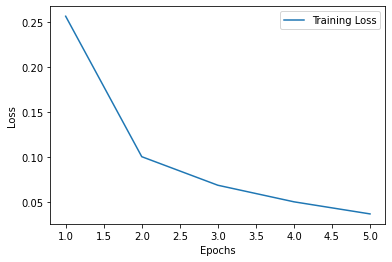

In [ ]:
# Plot the training loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

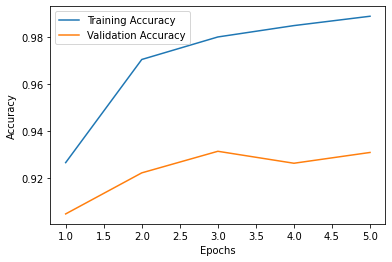

In [ ]:
# Plot the training and validation accuracy
plt.plot(range(1, epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Confusion matrix**




In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
@torch.no_grad()
def get_all_prediction(model, loader):
    preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        batch_predictions = model(images)
        preds = torch.cat((preds, batch_predictions), dim = 0)
    return preds

Confusion matrix, without normalization
[[5982    2    2    1    3    1    0    2    6    1]
 [   1 5953   29    2    0    3    0    2    9    1]
 [   0    2 5976    8    0    4    1    0    8    1]
 [   0    2    6 5989    0    2    0    1    0    0]
 [  39    1   19   11 5894   14    1    8    8    5]
 [   7    1   17   48    1 5922    0    1    3    0]
 [  12   20  341   95   22   25 5435   16   29    5]
 [   2    1    8    6    1    0    0 5976    4    2]
 [   3    3   12    3    0    0    1    1 5976    1]
 [   2    4   13    2    1    2    0    3    4 5969]]


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12363 missing from current font.
  font.set_

<Figure size 7200x7200 with 0 Axes>

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12375 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12373 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12381 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12377 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12363 missing from current font.
  font.set_text(s, 0,

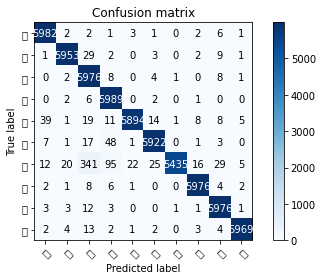

In [ ]:
np.set_printoptions(precision=2)

train_preds = get_all_prediction(convModel, train_Dloader)
label_dict = {
    "か",
    "き",
    "く",
    "け",
    "こ",
    "さ",
    "し",
    "す",
    "せ",
    "そ"
}


# Plot non-normalized confusion matrix


plt.figure(figsize=(100,100))
plot_confusion_matrix(train_data.targets, train_preds.argmax(dim=1), classes=label_dict,
                      title='Confusion matrix')

plt.show()

#Visualize The Wrong Predicted Labels :





/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


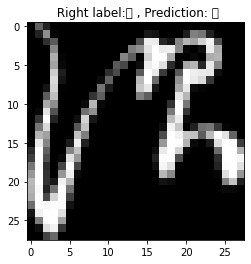

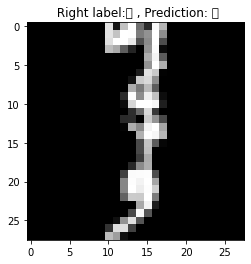

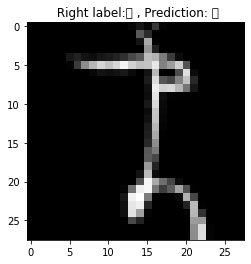

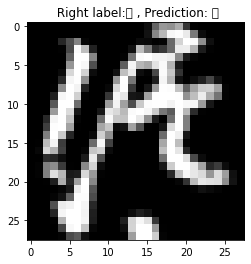

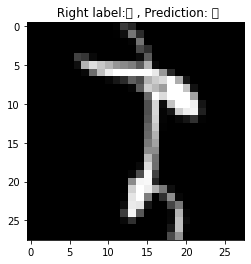

In [ ]:
convModel.eval()

# Initialize a list to store the wrong predictions
wrong_predictions = []


labels_pred= [
    "か",
    "き",
    "く",
    "け",
    "こ",
    "さ",
    "し",
    "す",
    "せ",
    "そ"
]


# Iterate through the test dataset
for i, (image, labels) in enumerate(test_data):
    # Make a prediction
    output = convModel(image.unsqueeze(0))
    pred = output.argmax(dim=1)
    # Compare the predicted label with the true label
    if pred != labels:
        # Append the image, true label, and predicted label to the list
        wrong_predictions.append((image, labels, pred))

# Display the wrong predictions
counter=5
for image, labels, pred in wrong_predictions: 
    plt.imshow(image.squeeze(), cmap='gray')
    pred_list=pred.tolist()
    plt.title(f' Right label:{labels_pred[labels]} , Prediction: {labels_pred[pred_list[0]]}')
    plt.show()
    counter-=1
    if counter==0:
      break
    

# Visualize The Correct Predicted Labels :

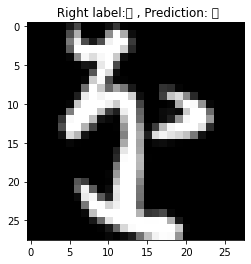

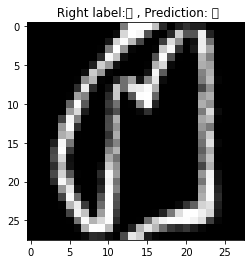

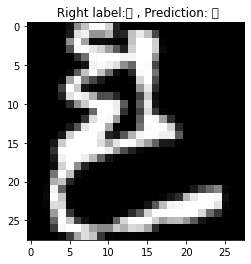

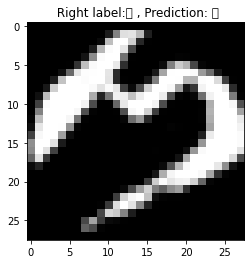

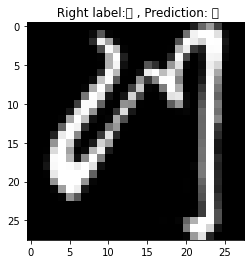

In [ ]:
convModel.eval()

# Initialize a list to store the wrong predictions
true_predictions = []

# Iterate through the test dataset
for i, (image, labels) in enumerate(test_data):
    # Make a prediction
    output = convModel(image.unsqueeze(0))
    pred = output.argmax(dim=1)
    # Compare the predicted label with the true label
    if pred == labels:
        # Append the image, true label, and predicted label to the list
        true_predictions.append((image, labels, pred))

# Display the wrong predictions
counter=5
for image, labels, pred in true_predictions: 
    plt.imshow(image.squeeze(), cmap='gray')
    pred_list=pred.tolist()
    plt.title(f' Right label:{labels_pred[labels]} , Prediction: {labels_pred[pred_list[0]]}')
    plt.show()
    counter-=1
    if counter==0:
      break

*****************************************